# Exploring Loudness as a Predictive Variable

### What is the loudness variable?

segments_loudness_max: "peak loudness value within the segment"
segments_loudness_max_time: "offset within the segment of the point of maximum loudness"
segments_loudness_start: "indicates the loudness level at the start of the segment"

Since, segments are such short measures of time, typically a quarter of a second or so, I felt that it was okay to just use the loudness_max variable over time.

In [2]:
import os
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import itertools
import re
import functools
import operator 

from scipy import signal
from scipy.signal import find_peaks_cwt
from scipy.fftpack import fft, ifft
%matplotlib inline

In [3]:
def get_filenames(path):
    return([get_filenames(path+"/"+entry.name)
            if entry.is_dir() 
            else path+"/"+entry.name 
            for entry 
            in os.scandir(path)
           ])

def unlist(alist):
    return(list(it.chain.from_iterable(alist)))

def var_list(base,numof):
    return([base+str(ndx) for ndx in range(numof)])

def h1d_array(in_array,n): 
    # n1d is the number of elements in `in_array`
    n1d = functools.reduce(operator.mul,
                           list(in_array.shape))
    # return a 1 row 2D array with `n` columns
    b = np.ndarray(shape=(1,n1d),
                   buffer=in_array,
                   dtype=in_array.dtype
                  )[0:1,0:n]
    return(b)

def fourier(a,plot):
    if len(a)<1:
        return([0,0],[0,0],[0,0])
    #a=a.iloc[0][~np.isnan(a.iloc[0])][0:-1]
    #a=a[a!=0]
    if len(a)<=10:
        return([0,0],[0,0],[0,0])
    #N = 600
    N = len(a)
    # sample spacing frequency
    T = 1.0
    x = np.linspace(0.0, N*T, N)
    y = signal.detrend(a)
    yf = fft(y)
    xf = np.linspace(0.0, T/(2.0*T), N/2)
    if plot==True:
        fig = plt.figure(1, figsize=(19,8))
        plt.subplot(2,1,1)
        plt.plot(a)
        plt.subplot(2,1,2)
        plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
    #return([xf,2.0/N*np.max(abs((yf[0:N/2])))])
    strength=(2.0/N*(np.abs((yf[0:N/2]))))
    p=(signal.find_peaks_cwt(strength, np.arange(1,20)))
    
    #strength_sort=sorted(strength)
    peak_strength=sorted(strength[p])
    #max_strength=max(strength)

    if len(peak_strength) >= 3:
        s1=peak_strength[-1]
        s2=peak_strength[-2]
        s3=peak_strength[-3]
    if len(peak_strength) == 2:
        s1=peak_strength[-1]
        s2=peak_strength[-2]
        s3=peak_strength[-2]
    if len(peak_strength) == 1:
        s1=peak_strength[-1]
        s2=peak_strength[-1]
        s3=peak_strength[-1]
    if len(peak_strength) == 0:
        return([0,0],[0,0],[0,0])
       
    freq=xf
    #max_freq=1/freq[strength==max_strength]
    f1=1/freq[strength==s1]
    f2=1/freq[strength==s2]
    f3=1/freq[strength==s3]
    
    #plt.plot(np.abs(yf))
    
  
    return[ [s1,f1[0]],[s2,f2[0]],[s3,f3[0]]]
    

Helper Functions from Professor Oury

In [4]:
def make_1row_df(filename='', metadata_vars=[], analysis_vars=[], remove=False):
    # open `filename` as a HDF5 file
    store = pd.HDFStore(filename,"r")
    if remove==True:
        # `metadata_vars` and `analysis_vars` contain the variables to remove
        metadata_vars = list({item for item 
                                  in list(store.root.metadata.songs.read().dtype.names) 
                                  if item not in metadata_vars})
        analysis_vars = list({item for item 
                                  in list(store.root.analysis.songs.read().dtype.names) 
                                  if item not in analysis_vars})
    # else: `metadata_vars` and `analysis_vars` contain the variables to keep
    
    # retrieve the first `n` values as a horizontal array of 1 dimension
    segments_loudness_max = h1d_array(store.root.analysis.segments_loudness_max.read(),36)
    ##segments_timbre  = h1d_array(store.root.analysis.segments_timbre.read(),36)
    ##bars_confidence  = h1d_array(store.root.analysis.bars_confidence.read(),10)
    ##artist_terms     = h1d_array(store.root.metadata.artist_terms.read(),3)
    
    # store these values as variables in single dataframes
    lm_df = pd.DataFrame(segments_loudness_max    ,columns=var_list('lm_',segments_loudness_max    .shape[1]))
    ##bc_df = pd.DataFrame(bars_confidence ,columns=var_list('bc_',bars_confidence .shape[1]))
    ##sp_df = pd.DataFrame(segments_pitches,columns=var_list('sp_',segments_pitches.shape[1]))
    ##st_df = pd.DataFrame(segments_timbre ,columns=var_list('st_',segments_timbre .shape[1]))

    # get track from filename
    match = re.split('\/',filename)
    match[-1]
    match = re.split('\.',match[-1])
    
    # merge these single dataframes into one single row dataframe
    ret = pd.concat([
            # make single row dataframe from track
            pd.DataFrame([match[0]], columns=['track']),
            # retrieve a single row dataframe from `/metadata/songs`
            pd.DataFrame(store.root.metadata.songs.read(), 
                         columns=metadata_vars),
            # retrieve a single row dataframe from `/analysis/songs`
            pd.DataFrame(store.root.analysis.songs.read(), 
                         columns=analysis_vars),
            #at_df, 
            ##bc_df, 
            ##sp_df,
            lm_df],
            axis=1) # `axes=1` means stack the dataframes horizontally 
    # close the HDF5 file
    store.close()
    # return the merged dataframe
    return(ret)

In [7]:
x = unlist(unlist(unlist(get_filenames(path))))
y = [filename for filename in x if p.search(filename)]


NameError: name 'p' is not defined

In [166]:
def get_loudness(file):
    store=pd.HDFStore(y[file],auto_close=True)
    m=(np.array(store.root.analysis.segments_loudness_max.read()))
    store.close()
    return(m)

Function to Create the DataFrame

In [6]:
#path = "/Users/mydlo_nich/Documents/Machine Learning/MillionSongSubset/data"
path = "/Users/mikebrennan/desktop/MillionSongSubset/data"
filenames = unlist(unlist(unlist(get_filenames(path))))
filenames[0:2]

['/', 'U']

In [72]:
p = re.compile("\.h5$")
filenames = [filename for filename 
             in filenames if p.search(filename)]
filenames[0:2]

len(filenames)

10000

In [143]:
test = make_1row_df(filename=filenames[9999],
                                metadata_vars=['artist_familiarity','artist_hotttnesss',
                                           'song_hotttnesss','title','artist_name','song_id'
                                        ],
                            # Omit: genre
                            analysis_vars=['duration','key','mode','loudness',
                                           'tempo','time_signature'],
                            # Omit: danceability, energy
                            remove=False
                           )

##test.columns
test.head(10)

,track,artist_familiarity,artist_hotttnesss,song_hotttnesss,title,artist_name,song_id,duration,key,mode,...,lm_26,lm_27,lm_28,lm_29,lm_30,lm_31,lm_32,lm_33,lm_34,lm_35
0,TRBIJYB128F14AE326,0.609182,0.509243,0.780312,b'Shattered Life',b'Seventh Day Slumber',b'SOFAOMI12A6D4FA2D8',209.73669,2,0,...,-16.846,-11.836,-14.618,-13.101,-16.847,-12.068,-13.23,-19.128,-11.88,-13.461


In [170]:
get_loudness(0)

array([-60.   , -31.646, -34.565, -38.407, -34.696, -20.511, -18.919,
       -21.477, -25.9  , -23.011, -20.598, -19.805, -21.222, -20.432,
       -28.022, -34.927, -29.401, -28.001, -18.132, -32.869, -36.764,
       -29.322, -20.021, -24.552, -41.055, -18.448, -18.232,  -9.656,
        -9.718, -16.525, -17.739,  -9.871, -17.369,  -9.493, -18.296,
       -17.17 , -18.037, -26.947,  -9.616, -12.048, -10.813, -10.22 ,
       -12.488, -17.914, -25.179, -12.849,  -8.758, -11.848,  -9.867,
       -14.918, -16.477, -12.302, -11.31 , -14.388, -10.922,  -8.27 ,
       -10.003, -10.464, -17.697, -17.604,  -8.914, -10.226, -12.403,
       -12.699,  -8.748, -13.511, -15.141,  -8.725,  -9.374, -15.494,
       -10.698,  -7.889,  -8.524, -10.545, -11.413, -13.845, -16.668,
        -8.857, -12.993, -11.349, -14.074, -12.878, -12.789,  -8.737,
       -12.071, -11.296, -13.16 , -16.822, -16.245, -11.888, -14.716,
        -8.284, -10.717, -17.063, -12.333, -13.186, -11.168,  -9.067,
       -14.331, -13.

In [73]:
#os.chdir("/Users/mydlo_nich/Dropbox/MA 755 Team Folder")
#curr_path = os.getcwd()
team_pickle = pd.read_pickle(curr_path+'/team_data_set.pkl')

Loudness_list here is just a list with each element containing an array of all of the max loudness measures per segment of each of our 10k songs

In [105]:
loudness_list = []
for i in range(10000):
    loudness_list.append(get_loudness(i))

In [133]:
##np.array(loudness_list[0])[0].tolist()
##loudness_list[0][0]

These three lists are capturing the average of the loudness measure over the first and second half of the song.

The point here is to create a variable to further our clustering similarity strength in the next phase. This measure could be a proxy for the "build" of the song, showing whether it starts slow and ends strong or just remains on one end of the spectrum the entire time.

In [108]:
loudness_avg1 = []
loudness_avg2 = []
loudness_diff = []

for song in range(10000):
    length_larray = len(loudness_list[song])
    ##print(length_larray)
    midpoint = round(length_larray/2)
    avg1 = 0
    count1 = 0
    count2 = 0
    avg2 = 0
    
    for l_seg in range(midpoint):
        avg1 = avg1 + loudness_list[song][l_seg]
        count1 = count1 + 1
    
    for l_seg in range(midpoint+1,length_larray):
        avg2 = avg2 + loudness_list[song][l_seg]
        count2 = count2 + 1
      
    avg1 = avg1/count1
    avg2 = avg2/count2
    
    loudness_diff.append(avg2-avg1)
    

In [109]:
len(loudness_diff)

10000

In [154]:
loudness_diff[:10]

[-0.35342088392342497,
 -1.0671093165229095,
 -0.65380997712251698,
 -1.8743048780487843,
 0.33464583333332865,
 4.5485828464298965,
 -6.9024375000000013,
 2.9545550718580884,
 2.0066204839020738,
 1.067580657580649]

This function works to smooth out the erratic segment by segment measures of loudness through the use of an exponentially weighted moving average.

We will either use the raw data averages to compute a first vs second half loudness metric or use the smoothed over data.

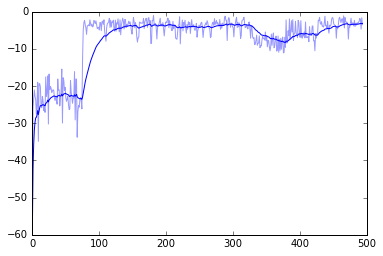

In [178]:
def graph_raw_Exp(x):
    ewma = pandas.stats.moments.ewma
    plt.plot( x, alpha=0.4, label='Raw' )
  
    # take EWMA in both directions with a smaller span term
    fwd = ewma( x, span=15 ) # take EWMA in fwd direction
    bwd = ewma( x[::-1], span=15 ) # take EWMA in bwd direction
    c = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
    c = np.mean( c, axis=0 ) # average
     
    # regular EWMA, with bias against trend
    plt.plot( ewma( x, span=35 ), 'b', label='EWMA, span=20' )
    
graph_raw_Exp(loudness_list[750])

Using Mike's Fourier Transform method, we are going to look at patterns in the loudness measures just as we are with pitch patterns.

//anaconda/envs/bunnies/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/bunnies/lib/python3.5/site-packages/ipykernel/__main__.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[1.408664018272612, 242.0],
 [0.61288282493777912, 4.8643216080402008],
 [0.60404596495172869, 6.4533333333333331]]

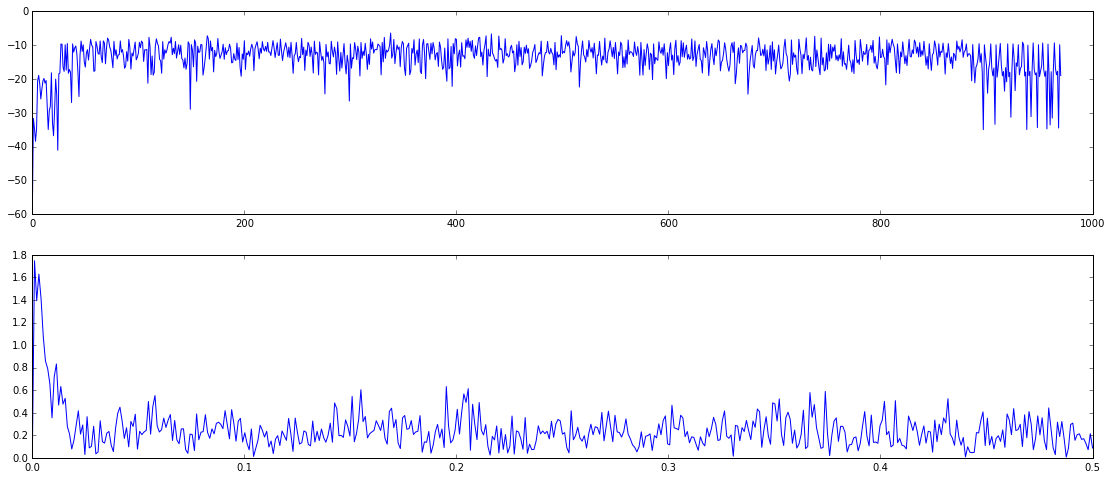

In [135]:
fourier(loudness_list[0],True)

This list contains the number of the song for later indexing as well as the top three most common frequency patterns and their occurence rate.

In [137]:
fourier_loud = []
for i in range(10000):
    result=fourier(loudness_list[i],False)
    fourier_loud.append([i,result[0][0],result[0][1],result[1][0],result[1][1],result[2][0],result[2][1]])
    if i%500 == 0:
        print (i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


//anaconda/envs/bunnies/lib/python3.5/site-packages/ipykernel/__main__.py:48: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [141]:
len(fourier_loud)
fourier_loud[0]

[0,
 1.408664018272612,
 242.0,
 0.61288282493777912,
 4.8643216080402008,
 0.60404596495172869,
 6.4533333333333331]

In [120]:
team_pickle.columns

Index(['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'title',
       'artist_name', 'artist_location', 'release', 'artist_longitude',
       'artist_latitude', 'duration', 'key', 'loudness', 'mode', 'tempo',
       'time_signature', 'end_of_fade_in', 'start_of_fade_in', 'year', 'at_0',
       'at_1', 'at_2', 'tim_comp_0', 'tim_comp_1', 'tim_comp_2', 'tim_comp_3',
       'tim_comp_4', 'tim_comp_5', 'tim_comp_6', 'tim_comp_7', 'tim_comp_8',
       'tim_comp_9', 'tim_comp_10', 'tim_comp_11', 'tim_comp_12',
       'tim_comp_13', 'tim_comp_14', 'song_id', 'pitch_length', 'max_segment',
       'mean_segment', 'key1', 'key2', 'key3', 'key4', 'key5', 'key6', 'key7',
       'key8', 'key9', 'key10', 'key11', 'key12', 'song_id_2', 's1', 'f1',
       's2', 'f2', 's3', 'f3', 'repeat_score'],
      dtype='object')

In [142]:
team_pickle[['title','song_id_2']]

,title,song_id_2
0,"b""I Didn't Mean To""",0
1,b'Soul Deep',1
2,b'Amor De Cabaret',2
3,b'Something Girls',3
4,b'Face the Ashes',4
5,b'The Moon And I (Ordinary Day Album Version)',5
6,b'Keepin It Real (Skit)',6
7,b'Drop of Rain',7
8,b'Pink World',8
9,b'Insatiable (Instrumental Version)',9


## What's Next?

### Add the metrics computed above as variables to our master dataframe and commence with clustering analysis to determine pockets of similarity in our 10k songs

Clustering ideas include using a more robust K means++ clustering for optimal convergence and a computation approach to initial cluster selection.

### We will also put together a set of audio reference clips for a more concrete representation of our numerical findings by playing songs to convey meaning in graphs

In [59]:
##team_pickle["title"] = team_pickle["title"].apply(lambda x: x.decode('utf-8'))
##team_pickle["artist_name"] = team_pickle["artist_name"].apply(lambda x: x.decode('utf-8'))

In [121]:
#team_pickle.loc[((team_pickle["title"]=="Soul Deep") & (team_pickle["artist_name"]=="The Box Tops"))]